# Classical Inference Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm


In [6]:
# Load the numerical data
numerical_df = pd.read_csv('../data/clean_reclean/numerical_cleaned.csv')  # adjust path if needed

# Drop any rows with missing values (you can also impute instead)
numerical_df = numerical_df.dropna()


In [7]:
# Basic descriptive statistics
desc_stats = numerical_df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("Descriptive Statistics:\n", desc_stats)


Descriptive Statistics:
                         mean           std      min       25%       50%  \
Id                726.842105    420.769012      1.0     364.0     725.0   
LotFrontage        70.665477     24.266812     21.0      60.0      70.0   
LotArea         10122.956289   8129.302641   1300.0    7590.0    9416.0   
YearBuilt        1972.264942     30.967730   1880.0    1953.0    1974.0   
YearRemodAdd     1985.683318     21.025974   1950.0    1966.0    1995.0   
MasVnrArea        108.487957    189.500966      0.0       0.0       0.0   
BsmtFinSF1        438.399643    468.385038      0.0       0.0     374.0   
BsmtFinSF2         44.589652    157.828725      0.0       0.0       0.0   
BsmtUnfSF         594.125781    450.259657      0.0     250.0     506.0   
TotalBsmtSF      1077.115076    445.656500      0.0     803.0    1008.0   
1stFlrSF         1173.584300    386.174253    438.0     894.0    1097.0   
2ndFlrSF          353.258698    438.561788      0.0       0.0       0.0   


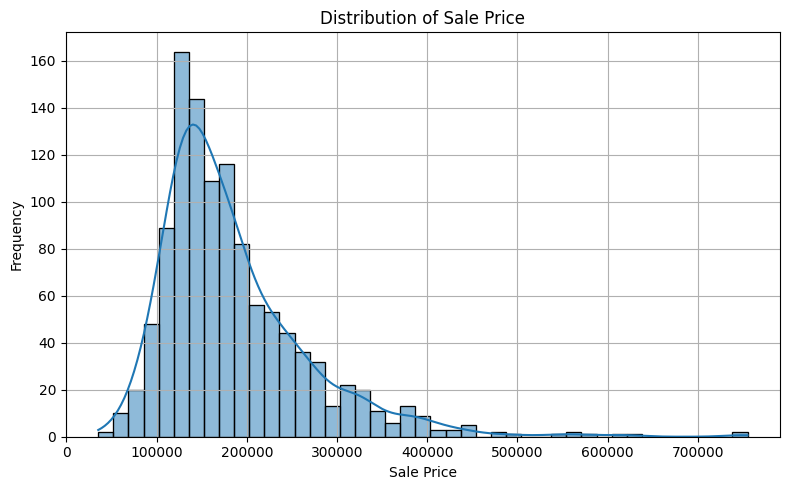

In [8]:
# Histogram of SalePrice
plt.figure(figsize=(8, 5))
sns.histplot(numerical_df['SalePrice'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


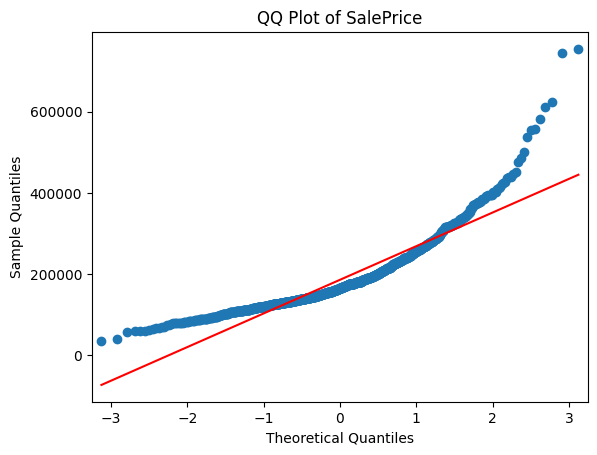

In [9]:
# QQ-Plot to assess normality
sm.qqplot(numerical_df['SalePrice'], line='s')
plt.title("QQ Plot of SalePrice")
plt.show()


In [10]:
# 95% Confidence Interval for SalePrice mean
sample_mean = numerical_df['SalePrice'].mean()
sample_std = numerical_df['SalePrice'].std()
n = len(numerical_df['SalePrice'])
conf_int = stats.t.interval(0.95, df=n-1, loc=sample_mean, scale=sample_std/np.sqrt(n))

print(f"\n95% Confidence Interval for SalePrice Mean: {conf_int[0]:,.2f} to {conf_int[1]:,.2f}")



95% Confidence Interval for SalePrice Mean: 180,642.21 to 190,370.10


In [11]:
# Hypothesis Test: Is the average SalePrice > $180,000?
# H0: mu = 180000, H1: mu > 180000
t_stat, p_value = stats.ttest_1samp(numerical_df['SalePrice'], popmean=180000)

print(f"\nT-statistic: {t_stat:.3f}")
print(f"One-tailed p-value (mean > 180000): {p_value / 2:.4f}")

if t_stat > 0 and (p_value / 2) < 0.05:
    print("Result: Reject H0 — The average SalePrice is significantly greater than $180,000.")
else:
    print("Result: Fail to reject H0 — No significant evidence that SalePrice > $180,000.")



T-statistic: 2.221
One-tailed p-value (mean > 180000): 0.0133
Result: Reject H0 — The average SalePrice is significantly greater than $180,000.


In [12]:
# Optional: Compute confidence intervals for other features
def feature_confidence_intervals(df, confidence=0.95):
    results = {}
    for col in df.columns:
        data = df[col]
        mean = data.mean()
        std = data.std()
        n = len(data)
        ci = stats.t.interval(confidence, df=n-1, loc=mean, scale=std/np.sqrt(n))
        results[col] = (round(ci[0], 2), round(ci[1], 2))
    return pd.DataFrame(results, index=[f'{int(confidence*100)}% CI Lower', f'{int(confidence*100)}% CI Upper']).T

ci_table = feature_confidence_intervals(numerical_df)
print("\nConfidence Intervals for Numerical Features:")
print(ci_table)



Confidence Intervals for Numerical Features:
               95% CI Lower  95% CI Upper
Id                   702.18        751.50
LotFrontage           69.24         72.09
LotArea             9646.56      10599.35
YearBuilt           1970.45       1974.08
YearRemodAdd        1984.45       1986.92
MasVnrArea            97.38        119.59
BsmtFinSF1           410.95        465.85
BsmtFinSF2            35.34         53.84
BsmtUnfSF            567.74        620.51
TotalBsmtSF         1051.00       1103.23
1stFlrSF            1150.95       1196.22
2ndFlrSF             327.56        378.96
LowQualFinSF           2.13          7.01
GrLivArea           1500.72       1562.10
BsmtFullBath           0.38          0.44
BsmtHalfBath           0.04          0.07
FullBath               1.55          1.61
HalfBath               0.35          0.41
BedroomAbvGr           2.82          2.91
KitchenAbvGr           1.03          1.05
Fireplaces             0.57          0.64
GarageCars             1.84   